In [1]:
import pandas as pd
import os
import numpy as np
from tensorflow.config import list_physical_devices

print("Num GPUs Available: ", len(list_physical_devices('GPU')))

Num GPUs Available:  1


2021-12-09 21:40:58.136157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 21:40:58.146514: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-09 21:40:58.147139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
project_base_dir = 'big-data-project/'
train_data_path = os.path.join(project_base_dir, "dataset2", "train", "data_train.csv")
test_data_path = os.path.join(project_base_dir, "dataset2", "test", "data_test.csv")
epochs = 60
batch_size = 32 # vary this parameter depending on your GPU capacity
num_classes= 3 # [normal, viral, bacterial]

In [124]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical

model = Sequential()
model.add(Dense(units=512, activation='tanh', input_dim=2048))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='sigmoid'))
# model.add(Dropout(0.2))
# model.add(Dense(units=64, activation='sigmoid'))
model.add(Dense(units=3, activation='softmax'))
model.summary()

optimizer = SGD(1e-3, momentum=0.9, nesterov=True)
# optimizer = Adam(1e-4)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_66 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_18 (Dropout)        (None, 512)               0         
                                                                 
 dense_67 (Dense)            (None, 256)               131328    
                                                                 
 dense_68 (Dense)            (None, 3)                 771       
                                                                 
Total params: 1,181,187
Trainable params: 1,181,187
Non-trainable params: 0
_________________________________________________________________


In [68]:
train_df = pd.read_csv(train_data_path, header=None)
test_df = pd.read_csv(test_data_path, header=None)

In [69]:
from sklearn.model_selection import train_test_split
y_train = to_categorical(train_df[0].values)
X_train = train_df.iloc[:, 1:].values
x_train, val_train, x_lab, val_lab = train_test_split(X_train, y_train, stratify=y_train, 
                                                      test_size=0.2, random_state=42)

y_test = (test_df[0].values)
x_test = test_df.iloc[:, 1:].values

In [70]:
# Allocate balanced weights to penalize over-represented classes
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
                class_weight='balanced',
                classes=np.unique(train_df[0].values), 
                y=train_df[0].values)
class_weights = {i:weight for i, weight in enumerate(class_weights)}
print(class_weights)

{0: 0.6666666666666666, 1: 1.9246592317224287, 2: 1.0199632256369846}


In [125]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
mcp_save = ModelCheckpoint(model.name + '.{epoch:02d}-{val_acc:.4f}.hdf5', save_best_only=True, monitor='val_loss', mode='min')
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='min')

history = model.fit(x_train, x_lab, validation_data=(val_train, val_lab), epochs=epochs, # class_weight=class_weights,
                    batch_size=64, verbose=1, callbacks=[earlyStopping, mcp_save])

Epoch 1/60
98/98 [==============================] - 1s 5ms/step - loss: 0.8326 - acc: 0.6566 - val_loss: 0.6551 - val_acc: 0.7671
Epoch 2/60
98/98 [==============================] - 0s 4ms/step - loss: 0.5913 - acc: 0.7646 - val_loss: 0.5260 - val_acc: 0.7735
Epoch 3/60
98/98 [==============================] - 0s 4ms/step - loss: 0.5058 - acc: 0.7770 - val_loss: 0.4692 - val_acc: 0.7838
Epoch 4/60
98/98 [==============================] - 0s 4ms/step - loss: 0.4628 - acc: 0.7894 - val_loss: 0.4397 - val_acc: 0.7947
Epoch 5/60
98/98 [==============================] - 0s 4ms/step - loss: 0.4355 - acc: 0.8042 - val_loss: 0.4179 - val_acc: 0.7986
Epoch 6/60
98/98 [==============================] - 0s 4ms/step - loss: 0.4174 - acc: 0.8166 - val_loss: 0.4009 - val_acc: 0.8121
Epoch 7/60
98/98 [==============================] - 0s 4ms/step - loss: 0.4014 - acc: 0.8245 - val_loss: 0.3887 - val_acc: 0.8153
Epoch 8/60
98/98 [==============================] - 0s 4ms/step - loss: 0.3906 - acc: 0.82

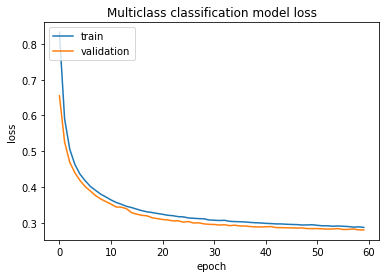

In [148]:
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Multiclass classification model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [143]:
# Measure accuracy on the test set
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model.load_weights('sequential_22.50-0.8790.hdf5') #change this to your path and model weights
preds = model.predict(x_test)
acc = accuracy_score(y_test, preds.argmax(axis=-1))
print('The accuracy of custom model is: ', acc)

The accuracy of custom model is:  0.8365384615384616


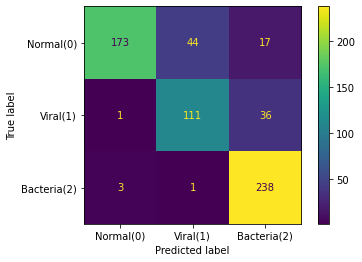

In [144]:
# Compute confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

cnf_matrix = confusion_matrix(y_test, preds.argmax(axis=-1))
cm_disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=["Normal(0)", "Viral(1)", "Bacteria(2)"])
cm_disp.plot()

In [147]:
# Print classification report
target_names = ['class 0(normal)', 'class 1(pneumonia viral)', 'class 1(pneumonia bacterial)'] #from the generator.class_indices
print(classification_report(y_test, preds.argmax(axis=-1), target_names=target_names, digits=3))

                              precision    recall  f1-score   support

             class 0(normal)      0.977     0.739     0.842       234
    class 1(pneumonia viral)      0.712     0.750     0.730       148
class 1(pneumonia bacterial)      0.818     0.983     0.893       242

                    accuracy                          0.837       624
                   macro avg      0.836     0.824     0.822       624
                weighted avg      0.852     0.837     0.835       624



ROC AUC score: 0.8715416054694268


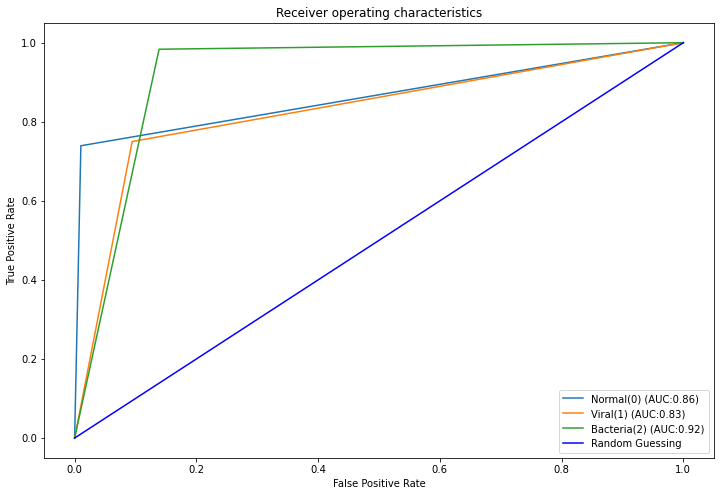

In [146]:
# Compute the ROC-AUC values

import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


target= ["Normal(0)", "Viral(1)", "Bacteria(2)"]

# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_test, preds.argmax(axis=-1)))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.title("Receiver operating characteristics")
plt.show()